# Assignment 7: Regularization - Bagging, Early Stopping and Dropout (deadline: 22 Dec, 23:59)

### Exercise 1. Regularization: Bagging (7 points)

**Goal:** Study the effects of **bagging** regularization on Decision Tree based methods against a single instance of such a classifier.

Bagging, briefly mentioned in the Lecture 6, refers to an ensemble machine learning method. The Bagging scheme, suggested to be used in this exercise, samples instances from the training data with replacement and creates multiple training subsets. For each of these subsets, a new regressor is constructed internally and finally, all combined to produce the result. For more details read: 

1. Scikit Learn Documentation for Bagging Regressor. http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#id6

2. Bootstrap Aggregating Wikipedia Article. https://en.wikipedia.org/wiki/Bootstrap_aggregating

Implement a bagging regularization scheme using ***DecisionTreeRegressor***, a Decision Tree based classifier from the python package ***sklearn.tree***. To implement the bagging scheme you can use ***BaggingRegressor*** available in the python package ***sklearn.ensemble***. Fill in the code pieces marked by "# TODO" in the following notebook to complete this assignment. Finally, comment on the results you obtain.

Note: to run the following code you will need to download **data.csv** from the NNIA's resource page on Piazza

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

`Define Estimators`: Create an array of two estimators. <br>
First a "Tree" using `DecisionTreeRegressor` and  <br>
second a Regularized version obtain using `BaggingRegressor` on this Tree, labelled "Bagging (Tree)". (2 points)

In [2]:
estimators = [("Tree", DecisionTreeRegressor()
              ),
              ("Bagging (Tree)", BaggingRegressor()
              )]

In [4]:
n_estimators = len(estimators)
np.random.seed(0)

#Load Data
data = pd.read_csv('data.csv')

#Drop Player Field
data = data.drop('Player', axis=1)

#Set variable y with 'Salary' column and then drop it from data
y = data['Salary'].as_matrix()
data = data.drop('Salary', axis=1)

#Convert data to an numpy array x
x = data.as_matrix()

# Split x in X_train (80 %) and X_test (20 %),  while constructing the corresponding y_train and y_test
n_train = np.int(0.8 * len(x) )
n_test = len(x) - n_train
X_train = x[:n_train,:]
y_train = y[:n_train]
X_test = x[n_train:,:]
y_test = y[n_train:]

Tree [  3.48100000e+03   6.00625000e+03   2.89000000e+04   4.22500000e+03
   5.62500000e+01   6.37562500e+04   9.00000000e+02   4.34013889e+02
   5.52250000e+04   8.12250000e+04   5.06250000e+02   9.02500000e+03
   9.00000000e+02   2.50000000e+01   2.50000000e+03   3.60000000e+05
   4.90000000e+03   6.25000000e+02   1.22500000e+05   2.35225000e+05
   1.65302449e+02   4.34013889e+02   2.11600000e+05   5.29000000e+04
   7.47109289e+04   3.02500000e+03   1.00000000e+04   1.62562500e+04
   1.03022500e+06   6.25000000e+02   1.45765297e+06   3.80281889e+03
   4.90000000e+03   4.62250000e+04   1.22500000e+05   9.00000000e+02
   6.25000000e+02   2.02500000e+05   6.40000000e+05   5.25625000e+03
   6.67359389e+04   1.60000000e+03   4.55625000e+05   2.64062500e+04
   1.05625000e+05   1.00000000e+04   2.50000000e+01   7.84000000e+02
   4.41000000e+04   1.28061632e+05   6.64225000e+05   4.98776289e+04
   2.60100000e+05]
Bagging (Tree) [  8.19025000e+03   1.68054147e+04   2.02950250e+03   2.14622500

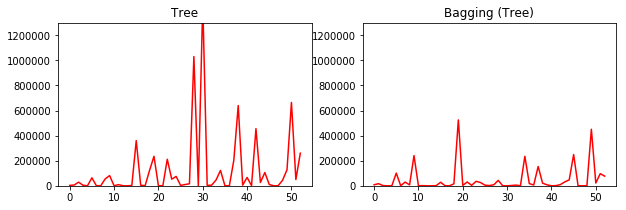

In [12]:
# Plot Figures and report error using the different ensemble methods
plt.figure(figsize=(10,3))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    
    # Compute predictions
    y_predict = np.zeros(n_test)
    #print(y_predict.shape)
    
    # Train the estimator (1 point)
    estimator.fit(X_train,y_train)
    
    #Predict results using the estimator on X_test (1 point)
    y_predict = estimator.predict(X_test)
    
    y_error = np.zeros(n_test)
    
    # Compute the mean squared error using y_test and y_predict and store it in y_error (1 point)
    y_error = (y_predict - y_test)**2
    
    #print("{0}: {1:.4f} (error)".format(name,y_error))
    #print("%s : %0.4f (error)" % (name,y_error))
    print(name,y_error)
    
    # Plot the Result
    plt.subplot(1,n_estimators,n+1)
    plt.plot(np.arange(n_test), y_error, "r", label="$error(x)$")
    plt.ylim([0, 1300000])
    plt.title(name)

plt.show()

a) Explain the differences (in 2-3 sentences) between the plots you obtain for **Tree** and **Bagging (Tree)**. (2 points)

**Answer:**

From the plots we can observe that the overall MSE of the Bagging ensemble method is smaller as the error from the Single Tree Regressor. In other words, in bagging we get a reduction of the MSE by increasing the bias by a "small" quantity compared to the "big" decrease in variance.

### Exercise 2. Regularization: Early Stopping (6 points)

**Goal:** To study how increasing neurons of a neural network (model complexity) affects the Early Stopping threshold.

Download **MNIST** dataset from the NNIA's resource page on Piazza. First, update the feedforward neural network code from  Assignment 6 to calculate training and validation error at every 100 iterations (also known as validation frequency) of the training scheme. For this update, you will modify the fit function and the signature of the function will look like follows. Notice the extra arguments that need to be provided to calculate the validation error at every 100 iterations. (2 points)

In [43]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """function for loading data"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('mnist/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

#cols = X_train.shape[0]
#X_val, Y_val = X_train[50000:][:], y_train[50000:][:]
#print('Rows: %d, columns: %d' % (X_val.shape[0], X_val.shape[1]))
#X_train, y_train = X_train[:50000][:], y_train[:50000][:]
#print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('mnist/', kind='t10k')
X_val, y_val = X_test, y_test
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [71]:

import numpy as np
from scipy.special import expit


class MLP(object):
    """ Feedforward neural network with a single hidden layer.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
        
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
        
    n_hidden : int
        Number of hidden units.
        
    l1 : float
        Regularizer for L1-regularization.
        l1=0.0 implies no regularization
        
    l2 : float
        Lambda value for L2-regularization.
        l2=0.0 implies no regularization
        
    epochs : int
        Number of passes over the training set.
        
    eta : float (default: 0.001)
        Learning rate.
        
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
        
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
        
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=50, eta=0.001,
                 decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):
        
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.w1, self.w2 = self.initialize_weights()
        self.cost_ = []
        self.val_cost_ = []
        self.cost2_ = []


    def encode_labels(self, y, k):
        """Encode the labels using one-hot representation

        Parameters
        ------------
        y : y represents target values.

        Returns
        -----------
        onehot array

        """
        label = np.zeros((k, y.shape[0]))
        for i,j in enumerate(y):
            label[j,i] = 1.0
        return label
        
        

    def initialize_weights(self):
        """Initialize using random numbers."""
        
        #w1 = np.random.uniform(-1.0, 1.0, size = [self.n_hidden, self.n_features+1])
        #w2 = np.random.uniform(-1.0, 1.0, size = [self.n_hidden, self.n_features+1])
        #return w1, w2
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def sigmoid(self, z):
        """Compute sigmoid function
           Implement a stable version which 
           takes care of overflow and underflow.
        """
        
        return expit(z)
        
        

    def sigmoid_gradient(self, z):
        """Compute gradient of the sigmoid function"""
        
        return self.sigmoid(z) * (1 - self.sigmoid(z))
        
        

    def add_bias_unit(self, X, how='column'):
        """Add bias unit to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        return X_new
        
        

    def feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array,
            Input values with bias unit.
        z2 : array,
            Net input of hidden layer.
        a2 : array,
            Activation of hidden layer.
        z3 : array,
            Net input of output layer.
        a3 : array,
            Activation of output layer.

        """
        
        a1 = self.add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self.sigmoid(z2)
        a2 = self.add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self.sigmoid(z3)
        return a1, z2, a2, z3, a3
        
        

    def L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))
        

    def L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())
        
        
    def get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, one-hot encoded class labels.
        
        output : array, Activation of the output layer (feedforward)
        
        w1 : array, Weight matrix for input layer -> hidden layer.
        w2 : array, Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float, Regularized cost.

        """
        
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self.L1_reg(self.l1, w1, w2)
        L2_term = self.L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
        
        

    def get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, Input values with bias unit.
        a2 : array, Activation of hidden layer.
        a3 : array, Activation of output layer.
        z2 : array, Net input of hidden layer.
        y_enc : array, one-hot encoded class labels.
        w1 : array, Weight matrix for input layer -> hidden layer.
        w2 : array, Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, Gradient of the weight matrix w1.
        grad2 : array, Gradient of the weight matrix w2.

        """
        
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self.add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self.sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2
        
        

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, Input layer with original features.

        Returns:
        ----------
        y_pred : array, Predicted class labels.

        """
        
        a1, z2, a2, z3, a3 = self.feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
        
    #def fit(self, X, y, print_progress=False, validation_freq=0, X_val=None, y_val=None):
    """ Learn weights from training data.

    Parameters
    -----------
    X : array, shape = [n_samples, n_features]
        Input layer with original features.
    y : array, shape = [n_samples]
        Target class labels.
    print_progress : bool (default: False)
        Prints progress as the number of epochs
        to stderr.
    validation_freq : int (default: 0)
        For the value "i" it takes, it calculates the 
        train set and validation set error every "ith" iteration
    X_val : array, shape = [n_validation_samples, n_features]
        the validation set X values, to be provided 
        when validation_freq > 0
    y_val : array, shape = [n_validation_samples]
        the validation set y values, to be provided
        when validation_freq > 0

    Returns:
    ----------
    self

    """    
    def fit(self, X, y, print_progress = False, validation_freq=0, x_val=None, y_val=None):
        
        X_data, y_data = X.copy(), y.copy()
        y_enc = self.encode_labels(y, self.n_output)

        n = 1
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self.feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self.get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self.get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= delta_w1 
                self.w2 -= delta_w2
            
            #First, update the feedforward neural network code from Assignment 6 to calculate training and validation error
            #at every 100 iterations (also known as validation frequency) of the training scheme. For this update, 
            #you will modify the fit function and the signature of the function will look like follows. 
            #Notice the extra arguments that need to be provided to calculate the validation error at every 100 iterations.
            if i == n*validation_freq - 1:
                # Trainig error
                '''a1, z2, a2, z3, a3 = self.feedforward(X_data,
                                                       self.w1,
                                                       self.w2)
                #cost = self.get_cost(y_enc=y_enc,
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)'''
                self.cost2_.append(cost)
                
                # Validation error
                a1, z2, a2, z3, a3 = self.feedforward(x_val,
                                                       self.w1,
                                                       self.w2)
                
                y_encoded = self.encode_labels(y_val, self.n_output)
                
                cost_vali = self.get_cost(y_enc=y_encoded,
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.val_cost_.append(cost_vali)
                
                n += 1

        return self


In [77]:
nn = MLP(n_output=10, 
                  n_features=X_train.shape[1], 
                  n_hidden=2, 
                  l2=0.1, 
                  l1=0.0, 
                  epochs=50, 
                  eta=0.001,
                  decrease_const=0.00001,
                  minibatches=50, 
                  shuffle=True,
                  random_state=1)

In [78]:
validation_frequency = 10
nn.fit(X_train, y_train, True, validation_frequency,X_val, Y_val)

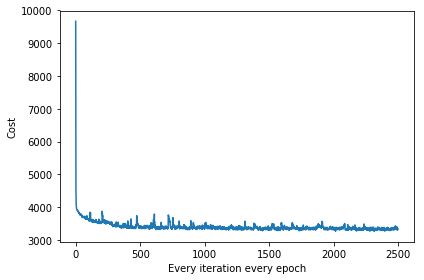

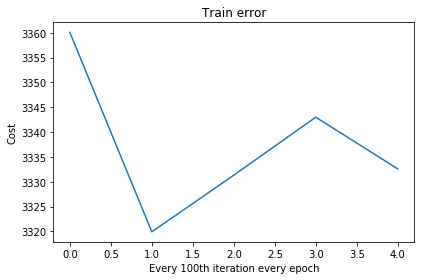

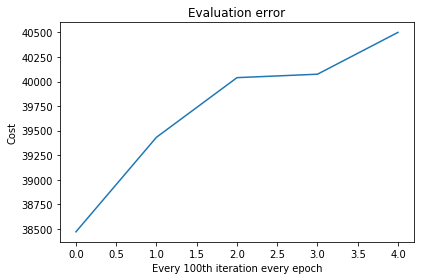

[38471.594475162645, 39432.816272738753, 40039.098040356075, 40074.207355672181, 40499.505372643922]


In [79]:
import matplotlib.pyplot as plt

# Plot the training error for every iteration
# in every epoch

# TODO Implement
plt.plot(range(len(nn.cost_)), nn.cost_)
#plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Every iteration every epoch')
#print(nn.cost_)
plt.tight_layout()
plt.show()

# Plot of 50 neurons
plt.plot(range(len(nn.cost2_)), nn.cost2_)
#plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Every 100th iteration every epoch')
plt.title('Train error')
#print(nn.cost_)
plt.tight_layout()
plt.show()
#print(nn.val_cost_)

# Plot of 50 neurons
plt.plot(range(len(nn.val_cost_)), nn.val_cost_)
#plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Every 100th iteration every epoch')
plt.title('Evaluation error')
#print(nn.cost_)
plt.tight_layout()
plt.show()
print(nn.val_cost_)

Then using this code for a different number of neurons (50, 100 and 200), plot the variation of training and validation error for every 100th iteration upto 1000 iterations. Label the axes and legends appropriately in the plots. (1.5 points)

Note: to caluclate the validation error use the test set as a proxy validation set.

a) Using these plots and the related variables from the code to make suggestions for an early stopping criteria for each hidden layer size. (1.5 points)

b) As the number of neurons are increased, you will observe differences in the early stopping criteria for each hidden layer size. Why do you observe such differences? (1 point)

### Exercise 3. Regularization: Dropout (7 points)

**Goal:** To implement and study dropout for neural networks.

Implement dropout for layer 2 in the three-layered network you developed for Exercise 2. A simple dropout implementation creates a mask ($r^{(l)}_j$) for every neuron $j$ of the hidden layer $l$ by drawing from a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with probability $p$.
$$ r^{(l)}_j \sim Bernoulli(p) $$
This mask is then applied to the hidden layer output ($h^{(l)}$) to obtain the regularized hidden layer activation $\hat{h}^{(l)}$
$$ \hat{h}^{(l)} = r^{(l)} * h^{(l)}$$
However, such an implementation requires the layerl be multiplied by the dropout coefficient $p$ at evaluation time to balance the larger number of active units during testing.
$$ \hat{h}^{(l)} = p * h^{(l)}$$
Such an implementation requires the code to switch between different code blocks for forward-pass evaluation during training and testing. Hence, a smoother way to implement dropout is to use ***inverted dropout*** where the mask generated at the training is multiplied by the inverse of the dropout coefficient.
$$ r^{(l)}_j \sim Bernoulli(p) * \frac{1}{p}$$
This scheme allows the scaling to be learned during training and hence, no switching between code blocks is required.

Update the code from Exercise 2 to implement inverted dropout for a hidden layer size of 200 neurons. (4 points)

a) Furthermore, update the code from Exercise 2 to plot the variation of training and test accuracies on MNIST for dropout values denoted by np.arange(0.0, 1.0, 0.1). (1.5 points)

b) Intuitively, L1 and L2 minimize the interdependence and the value of feature weights by penalising the loss function. In the same vein, what kind of interdependence does dropout affect? (0.5 points)

c) Why can Dropout be considered as an approximation to Bagging? (1 point)

---

## Submission instructions
You should provide a single Jupyter notebook as a solution. The naming should include the assignment number and matriculation IDs of all team members in the following format:
**assignment-7_matriculation1_matriculation2_matriculation3.ipynb** (in case of 3 team members). 
Make sure to keep the order matriculation1_matriculation2_matriculation3 the same for all assignments.

Please, submit your solution to your tutor (with **[NNIA][assignment-7]** in email subject):
1. Maksym Andriushchenko s8mmandr@stud.uni-saarland.de
2. Marius Mosbach s9msmosb@stud.uni-saarland.de
3. Rajarshi Biswas rbisw17@gmail.com
4. Marimuthu Kalimuthu s8makali@stud.uni-saarland.de

**If you are in a team, please submit only 1 solution to only 1 tutor.**